## **Problem Statement**

### Business Context

The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

### Problem Definition

With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.

As a member of the Data Science and AI team in the startup, you have been tasked with developing an AI-driven sentiment analysis system that will automatically process and analyze news articles to gauge market sentiment, and summarizing the news at a weekly level to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower their financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.

### Data Dictionary

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative

## **Installing and Importing the necessary libraries**

In [1]:
# installing the sentence-transformers and gensim libraries for word embeddings
!pip install numpy==1.26.4 \
             scikit-learn==1.6.1 \
             scipy==1.13.1 \
             gensim==4.3.3 \
             sentence-transformers==3.4.1 \
             pandas==2.2.2

Note:
- After running the above cell, kindly restart the runtime (for Google Colab) or notebook kernel (for Jupyter Notebook), and run all cells sequentially from the next cell.
- On executing the above line of code, you might see a warning regarding package dependencies. This error message can be ignored as the above code ensures that all necessary libraries and their dependencies are maintained to successfully execute the code in this notebook.

In [2]:
# Install missing packages
%pip install wordcloud nltk

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Text processing libraries
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import nltk

# Word embeddings
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer

# Machine learning libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Neural network libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import gc

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("All libraries imported successfully!")

Note: you may need to restart the kernel to use updated packages.
All libraries imported successfully!


## **Loading the dataset**

In [3]:
# Load the stock news dataset
stock_news = pd.read_csv("../data/stock_news.csv")

print("Dataset loaded successfully!")
print(f"Dataset shape: {stock_news.shape}")
print(f"Dataset memory usage: {stock_news.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Dataset loaded successfully!
Dataset shape: (349, 8)
Dataset memory usage: 0.16 MB


## **Data Overview**

In [4]:
# Display basic information about the dataset
print("=== DATASET OVERVIEW ===")
print(f"Shape: {stock_news.shape}")
print(f"Columns: {list(stock_news.columns)}")

print("\n=== FIRST FEW ROWS ===")
display(stock_news.head())

print("\n=== DATA TYPES ===")
print(stock_news.dtypes)

print("\n=== MISSING VALUES ===")
missing_values = stock_news.isnull().sum()
print(missing_values)

print("\n=== BASIC STATISTICS ===")
display(stock_news.describe())

print("\n=== UNIQUE VALUES IN EACH COLUMN ===")
for col in stock_news.columns:
    unique_count = stock_news[col].nunique()
    print(f"{col}: {unique_count} unique values")
    
print("\n=== LABEL DISTRIBUTION ===")
print(stock_news['Label'].value_counts().sort_index())

print("\n=== DATE RANGE ===")
stock_news['Date'] = pd.to_datetime(stock_news['Date'])
print(f"Date range: {stock_news['Date'].min()} to {stock_news['Date'].max()}")
print(f"Total days: {(stock_news['Date'].max() - stock_news['Date'].min()).days}")

=== DATASET OVERVIEW ===
Shape: (349, 8)
Columns: ['Date', 'News', 'Open', 'High', 'Low', 'Close', 'Volume', 'Label']

=== FIRST FEW ROWS ===


,Date,News,Open,High,Low,Close,Volume,Label
0,2019-01-02,The tech sector experienced a significant dec...,41.740002,42.244999,41.482498,40.246914,130672400,-1
1,2019-01-02,Apple lowered its fiscal Q1 revenue guidance ...,41.740002,42.244999,41.482498,40.246914,130672400,-1
2,2019-01-02,Apple cut its fiscal first quarter revenue fo...,41.740002,42.244999,41.482498,40.246914,130672400,-1
3,2019-01-02,This news article reports that yields on long...,41.740002,42.244999,41.482498,40.246914,130672400,-1
4,2019-01-02,Apple's revenue warning led to a decline in U...,41.740002,42.244999,41.482498,40.246914,130672400,-1



=== DATA TYPES ===
Date       object
News       object
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
Label       int64
dtype: object

=== MISSING VALUES ===
Date      0
News      0
Open      0
High      0
Low       0
Close     0
Volume    0
Label     0
dtype: int64

=== BASIC STATISTICS ===


,Open,High,Low,Close,Volume,Label
count,349.000000,349.000000,349.000000,349.000000,3.490000e+02,349.000000
mean,46.229233,46.700458,45.745394,44.926317,1.289482e+08,-0.054441
std,6.442817,6.507321,6.391976,6.398338,4.317031e+07,0.715119
min,37.567501,37.817501,37.305000,36.254131,4.544800e+07,-1.000000
25%,41.740002,42.244999,41.482498,40.246914,1.032720e+08,-1.000000
50%,45.974998,46.025002,45.639999,44.596924,1.156272e+08,0.000000
75%,50.707500,50.849998,49.777500,49.110790,1.511252e+08,0.000000
max,66.817497,67.062500,65.862503,64.805229,2.444392e+08,1.000000



=== UNIQUE VALUES IN EACH COLUMN ===
Date: 71 unique values
News: 349 unique values
Open: 70 unique values
High: 70 unique values
Low: 71 unique values
Close: 71 unique values
Volume: 71 unique values
Label: 3 unique values

=== LABEL DISTRIBUTION ===
Label
-1     99
 0    170
 1     80
Name: count, dtype: int64

=== DATE RANGE ===
Date range: 2019-01-02 00:00:00 to 2019-04-30 00:00:00
Total days: 118


## **Exploratory Data Analysis**

### **Univariate Analysis**

* Distribution of individual variables
* Compute and check the distribution of the length of news content

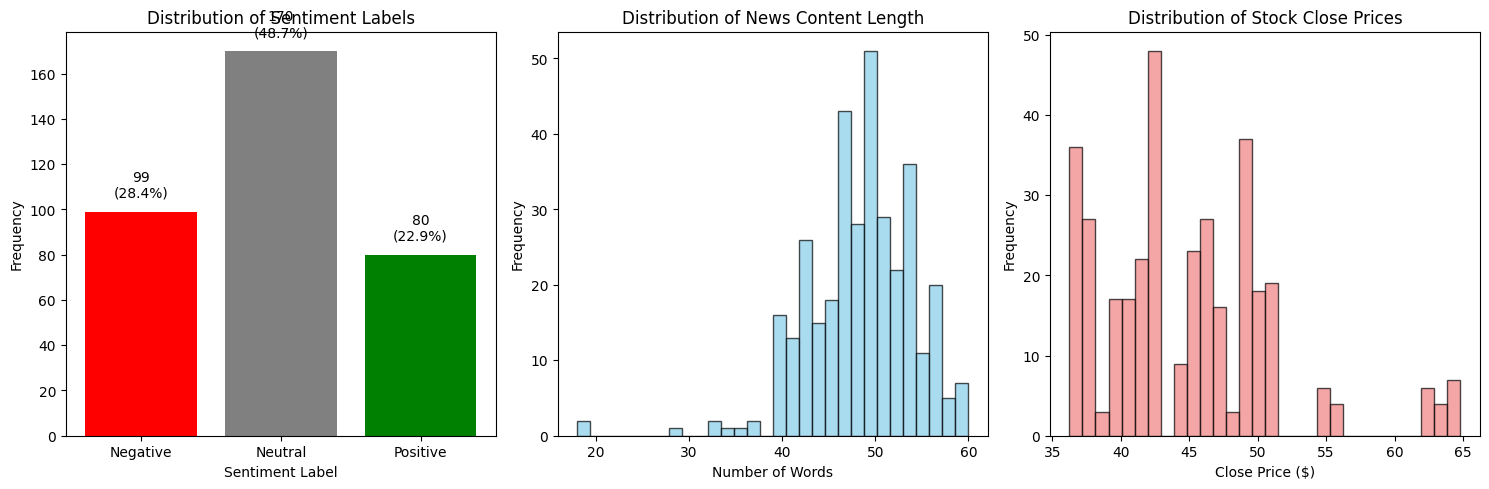

=== NEWS CONTENT LENGTH STATISTICS ===
count    349.000000
mean      48.349570
std        5.717324
min       18.000000
25%       45.000000
50%       49.000000
75%       52.000000
max       60.000000
Name: news_length, dtype: float64

=== NEWS CHARACTER LENGTH STATISTICS ===
count    349.000000
mean     311.237822
std       39.079467
min      110.000000
25%      290.000000
50%      315.000000
75%      336.000000
max      394.000000
Name: news_char_length, dtype: float64


In [5]:
# === UNIVARIATE ANALYSIS ===

# 1. Sentiment Label Distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sentiment_counts = stock_news['Label'].value_counts().sort_index()
colors = ['red', 'gray', 'green']
bars = plt.bar(sentiment_counts.index, sentiment_counts.values, color=colors)
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment Label')
plt.ylabel('Frequency')
plt.xticks([-1, 0, 1], ['Negative', 'Neutral', 'Positive'])
for bar, count in zip(bars, sentiment_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             f'{count}\n({count/len(stock_news)*100:.1f}%)', 
             ha='center', va='bottom')

# 2. News Content Length Distribution
stock_news['news_length'] = stock_news['News'].apply(lambda x: len(x.split()))
plt.subplot(1, 3, 2)
plt.hist(stock_news['news_length'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of News Content Length')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

# 3. Stock Price (Close) Distribution
plt.subplot(1, 3, 3)
plt.hist(stock_news['Close'], bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
plt.title('Distribution of Stock Close Prices')
plt.xlabel('Close Price ($)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# News length statistics
print("=== NEWS CONTENT LENGTH STATISTICS ===")
print(stock_news['news_length'].describe())

# Character length analysis
stock_news['news_char_length'] = stock_news['News'].apply(len)
print("\n=== NEWS CHARACTER LENGTH STATISTICS ===")
print(stock_news['news_char_length'].describe())

### **Bivariate Analysis**

* Correlation
* Sentiment Polarity vs Price
* Date vs Price

**Note**: The above points are listed to provide guidance on how to approach bivariate analysis. Analysis has to be done beyond the above listed points to get maximum scores.

=== CORRELATION MATRIX ===


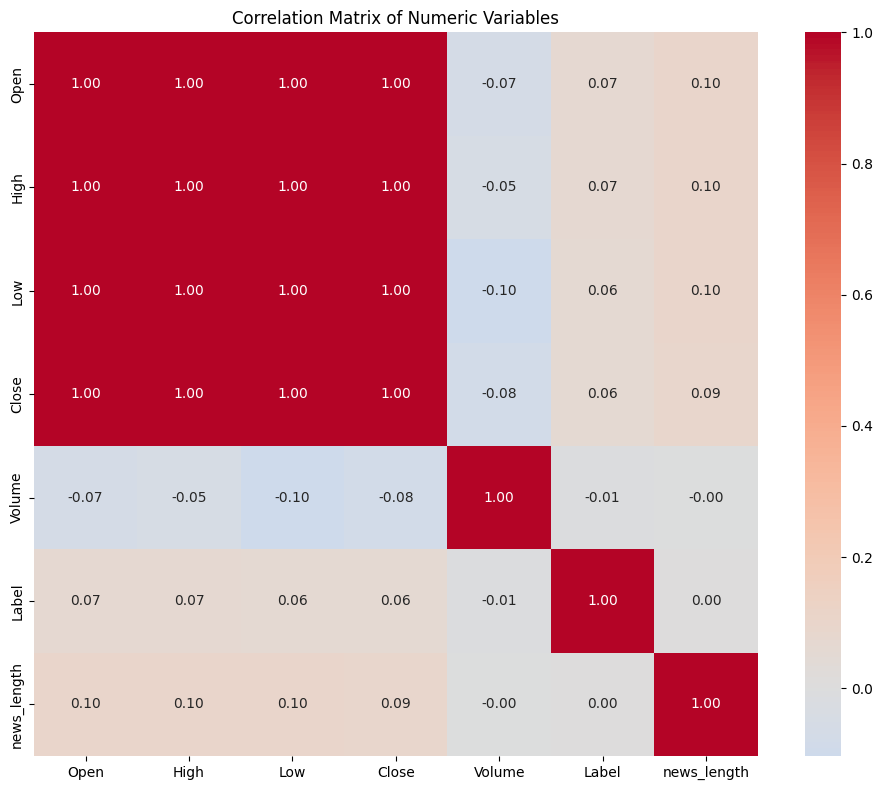

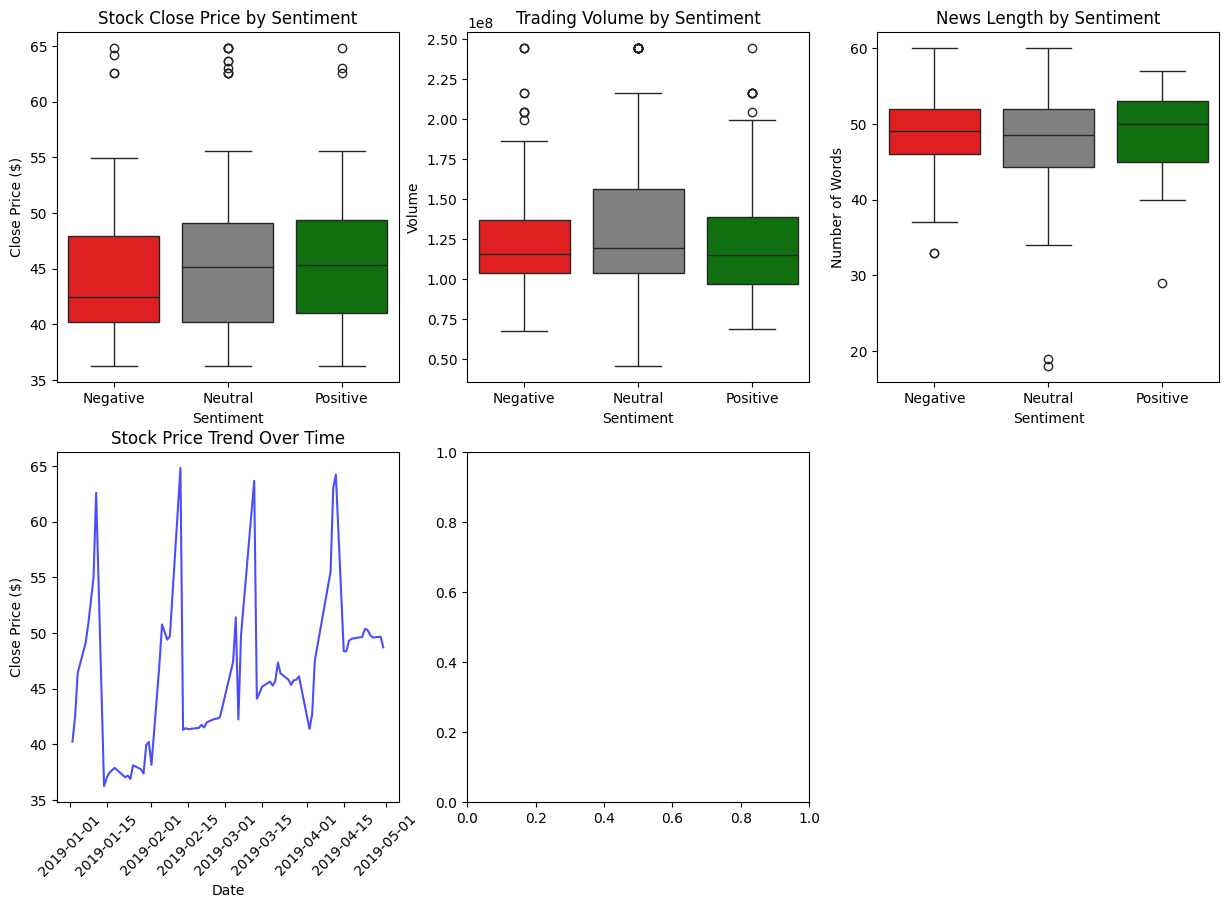

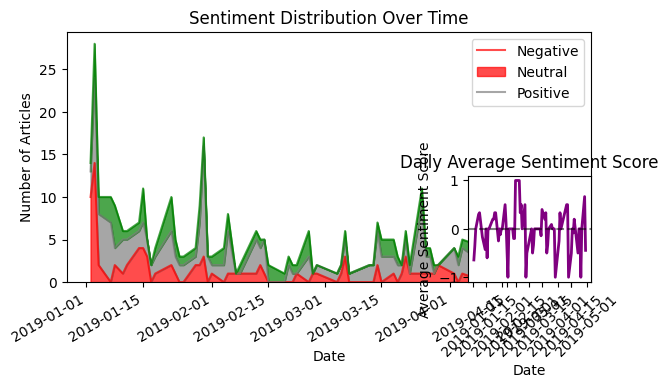


=== STOCK PRICE STATISTICS BY SENTIMENT ===


,count,mean,std,min,25%,50%,75%,max
sentiment_label,,,,,,,,
Negative,99.0,44.090725,6.064094,36.254131,40.246914,42.470604,47.929625,64.805229
Neutral,170.0,45.336195,6.611865,36.254131,40.227589,45.177055,49.110790,64.805229
Positive,80.0,45.089370,6.319505,36.254131,41.042676,45.308127,49.350196,64.805229



=== VOLUME STATISTICS BY SENTIMENT ===


,count,mean,std,min,25%,50%,75%,max
sentiment_label,,,,,,,,
Negative,99.0,1.268821e+08,4.088053e+07,67181600.0,103544800.0,115627200.0,137113600.0,244439200.0
Neutral,170.0,1.321492e+08,4.591709e+07,45448000.0,103544800.0,119339200.0,156171600.0,244439200.0
Positive,80.0,1.247030e+08,3.975521e+07,68998800.0,96783200.0,114843600.0,138664900.0,244439200.0


In [6]:
# === BIVARIATE ANALYSIS ===

# 1. Correlation Analysis
print("=== CORRELATION MATRIX ===")
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Label', 'news_length']
correlation_matrix = stock_news[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f')
plt.title('Correlation Matrix of Numeric Variables')
plt.tight_layout()
plt.show()

# 2. Sentiment vs Stock Price Analysis
plt.figure(figsize=(15, 10))

# Stock Close Price by Sentiment
plt.subplot(2, 3, 1)
sentiment_labels = {-1: 'Negative', 0: 'Neutral', 1: 'Positive'}
stock_news['sentiment_label'] = stock_news['Label'].map(sentiment_labels)
sns.boxplot(data=stock_news, x='sentiment_label', y='Close', 
            palette=['red', 'gray', 'green'])
plt.title('Stock Close Price by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Close Price ($)')

# Volume by Sentiment
plt.subplot(2, 3, 2)
sns.boxplot(data=stock_news, x='sentiment_label', y='Volume', 
            palette=['red', 'gray', 'green'])
plt.title('Trading Volume by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Volume')

# News Length by Sentiment
plt.subplot(2, 3, 3)
sns.boxplot(data=stock_news, x='sentiment_label', y='news_length', 
            palette=['red', 'gray', 'green'])
plt.title('News Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Number of Words')

# Stock Price over Time
plt.subplot(2, 3, 4)
plt.plot(stock_news['Date'], stock_news['Close'], alpha=0.7, color='blue')
plt.title('Stock Price Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.xticks(rotation=45)

# Sentiment Distribution over Time
plt.subplot(2, 3, 5)
sentiment_over_time = stock_news.groupby(['Date', 'Label']).size().unstack(fill_value=0)
sentiment_over_time.plot(kind='area', alpha=0.7, color=['red', 'gray', 'green'])
plt.title('Sentiment Distribution Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.legend(['Negative', 'Neutral', 'Positive'])

# Daily Average Sentiment Score
plt.subplot(2, 3, 6)
daily_sentiment = stock_news.groupby('Date')['Label'].mean()
plt.plot(daily_sentiment.index, daily_sentiment.values, color='purple', linewidth=2)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.title('Daily Average Sentiment Score')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Statistical analysis by sentiment
print("\n=== STOCK PRICE STATISTICS BY SENTIMENT ===")
sentiment_stats = stock_news.groupby('sentiment_label')['Close'].describe()
display(sentiment_stats)

print("\n=== VOLUME STATISTICS BY SENTIMENT ===")
volume_stats = stock_news.groupby('sentiment_label')['Volume'].describe()
display(volume_stats)

## **Data Preprocessing**

In [7]:
# === DATA PREPROCESSING ===

# Create train-test split based on temporal data (following solution pattern)
print("=== TRAIN-TEST SPLIT ===")
split_date = '2019-03-15'
print(f"Split date: {split_date}")

# Create temporal split
X_train = stock_news[stock_news['Date'] < split_date].copy().reset_index(drop=True)
X_test = stock_news[stock_news['Date'] >= split_date].copy().reset_index(drop=True)

# Extract target variables
y_train = X_train["Label"].copy()
y_test = X_test["Label"].copy()

print(f"Training set size: {len(X_train)} samples")
print(f"Test set size: {len(X_test)} samples")
print(f"Training period: {X_train['Date'].min()} to {X_train['Date'].max()}")
print(f"Test period: {X_test['Date'].min()} to {X_test['Date'].max()}")

# Check label distribution in both sets
print(f"\nTraining set label distribution:")
print(y_train.value_counts().sort_index())
print(f"\nTest set label distribution:")
print(y_test.value_counts().sort_index())

# Text preprocessing function (comprehensive approach)
def preprocess_text(text):
    """
    Comprehensive text preprocessing function
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and digits, keep only alphabets and spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespaces
    text = ' '.join(text.split())
    
    return text

# Apply preprocessing to news text
print("\n=== TEXT PREPROCESSING ===")
X_train['News_processed'] = X_train['News'].apply(preprocess_text)
X_test['News_processed'] = X_test['News'].apply(preprocess_text)

# Show example of preprocessing
print("Original text sample:")
print(X_train['News'].iloc[0][:200] + "...")
print("\nProcessed text sample:")
print(X_train['News_processed'].iloc[0][:200] + "...")

# Prepare word lists for Word2Vec (using processed text)
words_list = [item.split() for item in X_train['News_processed'].values]
print(f"\nTotal documents for Word2Vec training: {len(words_list)}")
print(f"Average words per document: {np.mean([len(words) for words in words_list]):.1f}")

# Display preprocessing statistics
print(f"\n=== PREPROCESSING STATISTICS ===")
train_word_counts = X_train['News_processed'].apply(lambda x: len(x.split()))
test_word_counts = X_test['News_processed'].apply(lambda x: len(x.split()))

print(f"Training set - Average words per article: {train_word_counts.mean():.1f}")
print(f"Test set - Average words per article: {test_word_counts.mean():.1f}")
print(f"Training set - Word count range: {train_word_counts.min()} to {train_word_counts.max()}")
print(f"Test set - Word count range: {test_word_counts.min()} to {test_word_counts.max()}")

=== TRAIN-TEST SPLIT ===
Split date: 2019-03-15
Training set size: 240 samples
Test set size: 109 samples
Training period: 2019-01-02 00:00:00 to 2019-03-14 00:00:00
Test period: 2019-03-15 00:00:00 to 2019-04-30 00:00:00

Training set label distribution:
Label
-1     70
 0    116
 1     54
Name: count, dtype: int64

Test set label distribution:
Label
-1    29
 0    54
 1    26
Name: count, dtype: int64

=== TEXT PREPROCESSING ===
Original text sample:
 The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks...

Processed text sample:
the tech sector experienced a significant decline in the aftermarket following apples q revenue warning notable suppliers including skyworks broadcom lumentum qorvo and tsmc saw their stocks drop in r...

Total documents for Word2Vec training: 240
Average words per document: 46.8

=== PREPROCESSING STATISTICS ===


## **Word Embeddings**

### **Generating Text Embeddings using Word2Vec**

In [8]:
# === WORD2VEC IMPLEMENTATION ===

print("=== TRAINING WORD2VEC MODEL ===")

# Set Word2Vec parameters (following solution pattern)
vec_size = 300
window_size = 5
min_count = 1
workers = 6

# Train Word2Vec model on the training data
model_W2V = Word2Vec(
    words_list, 
    vector_size=vec_size, 
    min_count=min_count, 
    window=window_size, 
    workers=workers,
    seed=42
)

print(f"Word2Vec model trained successfully!")
print(f"Vocabulary size: {len(model_W2V.wv.key_to_index)}")
print(f"Vector dimension: {vec_size}")

# Extract vocabulary and create word vector dictionary
words = list(model_W2V.wv.key_to_index.keys())
word_vector_dict = {word: model_W2V.wv[word] for word in words}

print(f"Word vector dictionary created with {len(word_vector_dict)} words")

# Show some example word similarities
print("\n=== EXAMPLE WORD SIMILARITIES ===")
try:
    similar_words = model_W2V.wv.most_similar("stock", topn=5)
    print("Words most similar to 'stock':")
    for word, similarity in similar_words:
        print(f"  {word}: {similarity:.3f}")
except:
    print("Word 'stock' not found in vocabulary")

try:
    similar_words = model_W2V.wv.most_similar("price", topn=5)
    print("\nWords most similar to 'price':")
    for word, similarity in similar_words:
        print(f"  {word}: {similarity:.3f}")
except:
    print("Word 'price' not found in vocabulary")

# Function to convert document to average Word2Vec vector
def average_vectorizer_Word2Vec(doc):
    """
    Convert a document to its average Word2Vec representation
    """
    # Initialize feature vector
    feature_vector = np.zeros((vec_size,), dtype="float64")
    
    # Get words present in vocabulary
    words_in_vocab = [word for word in doc.split() if word in words]
    
    # Average word vectors to create sentence vector
    if words_in_vocab:
        for word in words_in_vocab:
            feature_vector += np.array(word_vector_dict[word])
        feature_vector = feature_vector / len(words_in_vocab)
    
    return feature_vector

print("\n=== CREATING DOCUMENT VECTORS ===")

# Apply Word2Vec vectorization to training and test sets
X_train_wv = pd.DataFrame(
    X_train['News_processed'].apply(average_vectorizer_Word2Vec).tolist(), 
    columns=[f'W2V_Feature_{i}' for i in range(vec_size)]
)

X_test_wv = pd.DataFrame(
    X_test['News_processed'].apply(average_vectorizer_Word2Vec).tolist(), 
    columns=[f'W2V_Feature_{i}' for i in range(vec_size)]
)

print(f"Training set Word2Vec features shape: {X_train_wv.shape}")
print(f"Test set Word2Vec features shape: {X_test_wv.shape}")

# Show sample of the generated features
print(f"\nFirst 5 Word2Vec features for first document:")
print(X_train_wv.iloc[0, :5].values)

=== TRAINING WORD2VEC MODEL ===
Word2Vec model trained successfully!
Vocabulary size: 2730
Vector dimension: 300
Word vector dictionary created with 2730 words

=== EXAMPLE WORD SIMILARITIES ===
Words most similar to 'stock':
  the: 0.991
  and: 0.990
  a: 0.990
  of: 0.990
  to: 0.989

Words most similar to 'price':
  the: 0.988
  a: 0.988
  and: 0.987
  in: 0.987
  to: 0.987

=== CREATING DOCUMENT VECTORS ===
Training set Word2Vec features shape: (240, 300)
Test set Word2Vec features shape: (109, 300)

First 5 Word2Vec features for first document:
[ 0.0011731  -0.01169847 -0.00260217 -0.01446034  0.00446302]


### **Sentence Transformer**

In [9]:
# === SENTENCE TRANSFORMER IMPLEMENTATION ===

print("=== LOADING SENTENCE TRANSFORMER MODEL ===")

# Load pre-trained Sentence Transformer model (following solution pattern)
model_st = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

print("Sentence Transformer model loaded successfully!")
print(f"Model: all-MiniLM-L6-v2")
print(f"Expected output dimension: 384")

print("\n=== GENERATING SENTENCE EMBEDDINGS ===")

# Generate embeddings for training set using original News text (not processed)
X_train_st = model_st.encode(
    X_train["News"].values, 
    show_progress_bar=True, 
    device="cpu"
)

# Generate embeddings for test set
X_test_st = model_st.encode(
    X_test["News"].values, 
    show_progress_bar=True, 
    device="cpu"
)

print(f"Training set Sentence Transformer features shape: {X_train_st.shape}")
print(f"Test set Sentence Transformer features shape: {X_test_st.shape}")

# Convert to DataFrames for consistency
X_train_st_df = pd.DataFrame(
    X_train_st, 
    columns=[f'ST_Feature_{i}' for i in range(X_train_st.shape[1])]
)

X_test_st_df = pd.DataFrame(
    X_test_st, 
    columns=[f'ST_Feature_{i}' for i in range(X_test_st.shape[1])]
)

print(f"\nDataFrame shapes:")
print(f"Training set: {X_train_st_df.shape}")
print(f"Test set: {X_test_st_df.shape}")

# Show sample of the generated features
print(f"\nFirst 5 Sentence Transformer features for first document:")
print(X_train_st_df.iloc[0, :5].values)

# Compare embedding approaches
print(f"\n=== EMBEDDING COMPARISON ===")
print(f"Word2Vec dimensions: {X_train_wv.shape[1]}")
print(f"Sentence Transformer dimensions: {X_train_st_df.shape[1]}")
print(f"Word2Vec feature range: [{X_train_wv.values.min():.3f}, {X_train_wv.values.max():.3f}]")
print(f"Sentence Transformer feature range: [{X_train_st_df.values.min():.3f}, {X_train_st_df.values.max():.3f}]")

=== LOADING SENTENCE TRANSFORMER MODEL ===
Sentence Transformer model loaded successfully!
Model: all-MiniLM-L6-v2
Expected output dimension: 384

=== GENERATING SENTENCE EMBEDDINGS ===


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Training set Sentence Transformer features shape: (240, 384)
Test set Sentence Transformer features shape: (109, 384)

DataFrame shapes:
Training set: (240, 384)
Test set: (109, 384)

First 5 Sentence Transformer features for first document:
[-0.00202314 -0.03677348  0.07735426  0.04671347  0.0325521 ]

=== EMBEDDING COMPARISON ===
Word2Vec dimensions: 300
Sentence Transformer dimensions: 384
Word2Vec feature range: [-0.049, 0.046]
Sentence Transformer feature range: [-0.212, 0.235]


## **Sentiment Analysis**

### **Model Evaluation Criterion**

**Note:**  
You can use the helper functions provided below to:
- Plot a **confusion matrix** (`plot_confusion_matrix`)
- Generate key **classification metrics** like accuracy, recall, precision, and F1-score (`model_performance_classification_sklearn`)

These are ready-to-use. However, you’re welcome to explore and write your own evaluation code if you prefer. Feel free to modify or extend these as per your learning goals!

##### **Utility Functions**

In [10]:
def plot_confusion_matrix(actual, predicted):
    """
    Plot a confusion matrix to visualize the performance of a classification model.

    Parameters:
    actual (array-like): The true labels.
    predicted (array-like): The predicted labels from the model.

    Returns:
    None: Displays the confusion matrix plot.
    """

    # Compute the confusion matrix.
    cm = confusion_matrix(actual, predicted)

    # Create a new figure with a specified size
    plt.figure(figsize=(5, 4))

    # Define the labels for the confusion matrix dynamically from the data
    label_list = sorted(list(np.unique(np.concatenate((actual, predicted)))))

    # Plot the confusion matrix using a heatmap with annotations
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=label_list, yticklabels=label_list)

    # Label for the y-axis
    plt.ylabel('Actual')

    # Label for the x-axis
    plt.xlabel('Predicted')

    # Title of the plot
    plt.title('Confusion Matrix')

    # Display the plot
    plt.show()

In [11]:
def model_performance_classification_sklearn(actual, predicted):
    """
    Compute various performance metrics for a classification model using sklearn.

    Parameters:
    model (sklearn classifier): The classification model to evaluate.
    predictors (array-like): The independent variables used for predictions.
    target (array-like): The true labels for the dependent variable.

    Returns:
    pandas.DataFrame: A DataFrame containing the computed metrics (Accuracy, Recall, Precision, F1-score).
    """

    # Compute Accuracy
    acc = accuracy_score(actual,predicted)
    # Compute Recall
    recall = recall_score(actual,predicted,average='weighted')
    # Compute Precision
    precision = precision_score(actual,predicted,average='weighted')
    # Compute F1-score
    f1 = f1_score(actual,predicted,average='weighted')

    # Create a DataFrame to store the computed metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": [acc],
            "Recall": [recall],
            "Precision": [precision],
            "F1": [f1],
        }
    )
    # Return the DataFrame with the metrics
    return df_perf

### **Build Random Forest Models using different text embeddings**

=== BUILDING RANDOM FOREST MODELS ===
Random Forest parameters: {'n_estimators': 100, 'max_depth': 10, 'random_state': 42, 'n_jobs': -1}

=== Random Forest with Word2Vec Embeddings ===
Training Performance:


,Accuracy,Recall,Precision,F1
0,1.0,1.0,1.0,1.0


Test Performance:


,Accuracy,Recall,Precision,F1
0,0.486239,0.486239,0.448963,0.46177



=== Random Forest with Sentence Transformer Embeddings ===
Training Performance:


,Accuracy,Recall,Precision,F1
0,1.0,1.0,1.0,1.0


Test Performance:


,Accuracy,Recall,Precision,F1
0,0.486239,0.486239,0.457143,0.414659



=== RANDOM FOREST RESULTS VISUALIZATION ===


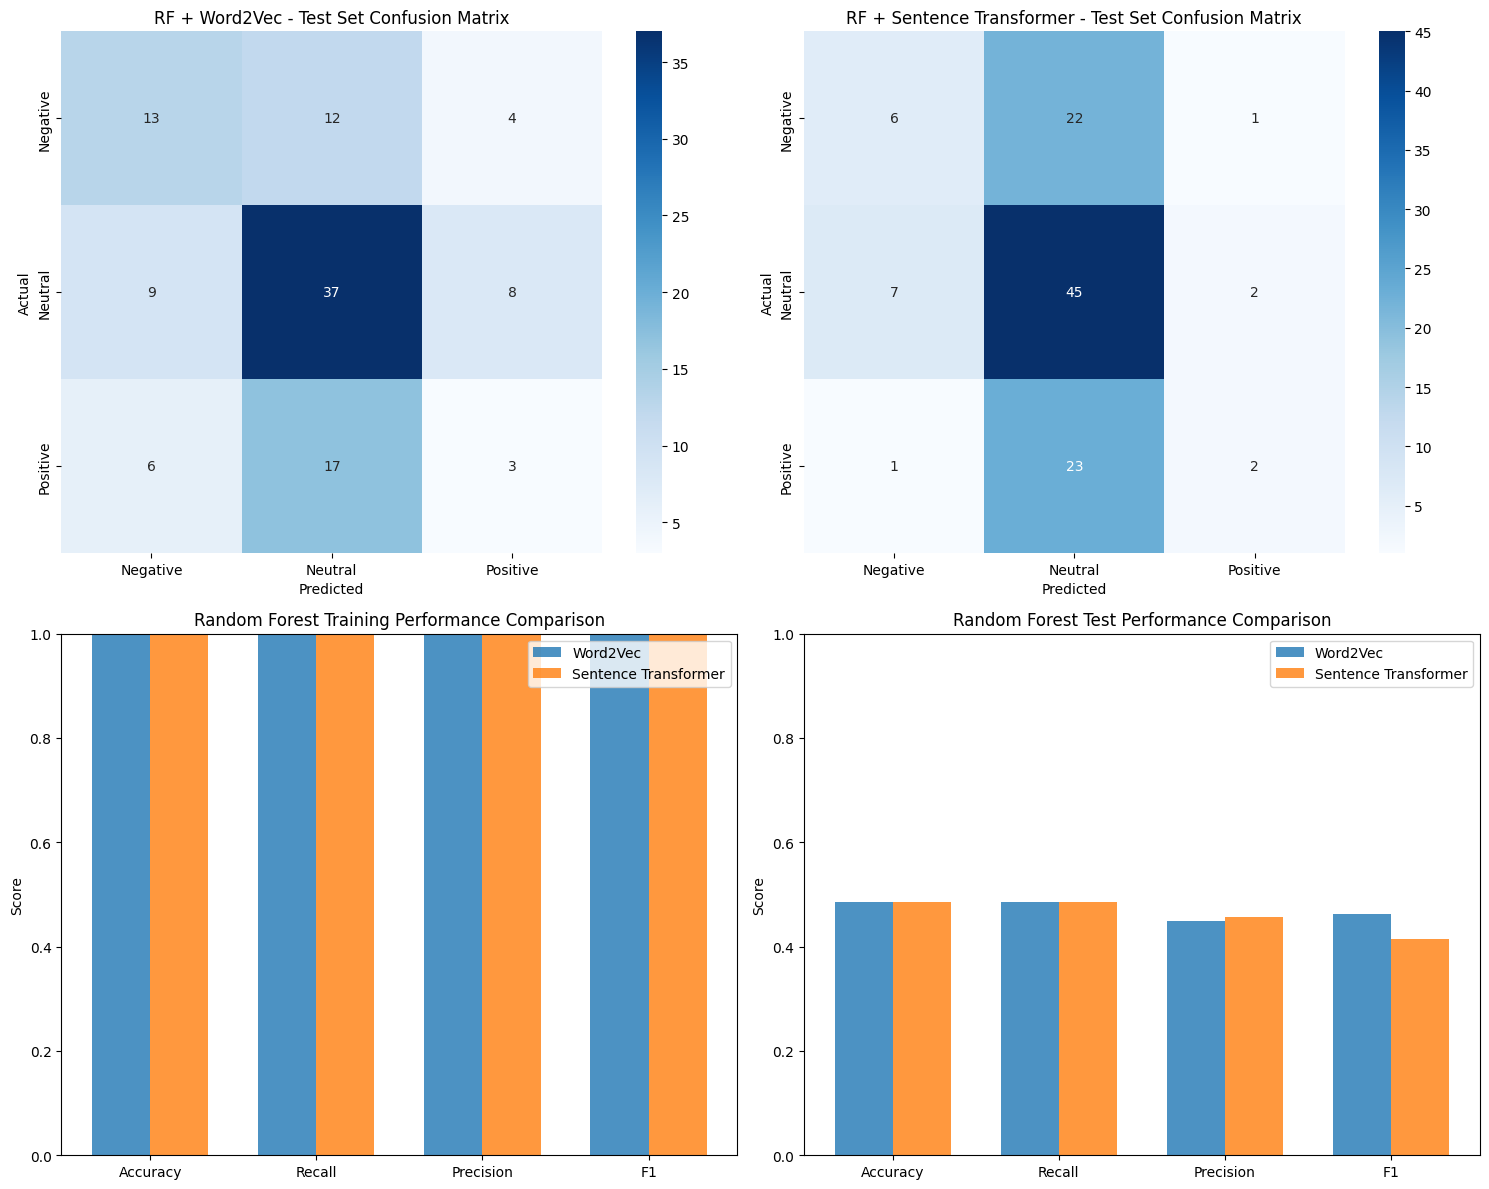


=== FEATURE IMPORTANCE ANALYSIS ===


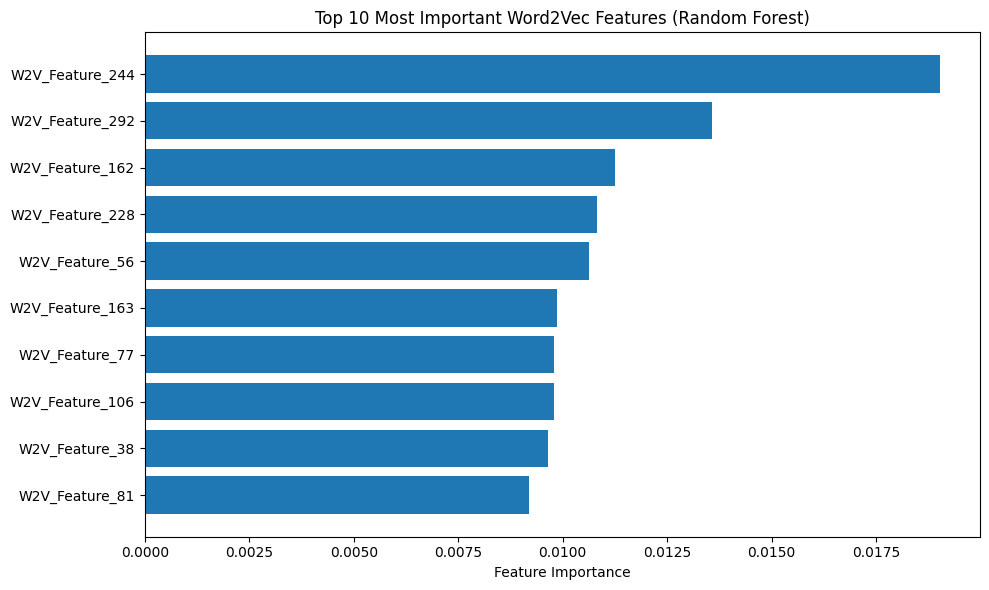

Random Forest models completed successfully!


In [12]:
# === RANDOM FOREST MODELS ===

print("=== BUILDING RANDOM FOREST MODELS ===")

# Model parameters (following solution pattern)
rf_params = {
    'n_estimators': 100,
    'max_depth': 10,
    'random_state': 42,
    'n_jobs': -1
}

print(f"Random Forest parameters: {rf_params}")

# ========================================
# Random Forest with Word2Vec Embeddings
# ========================================

print("\n=== Random Forest with Word2Vec Embeddings ===")

# Initialize and train the model
rf_w2v = RandomForestClassifier(**rf_params)
rf_w2v.fit(X_train_wv, y_train)

# Make predictions
y_pred_train_rf_w2v = rf_w2v.predict(X_train_wv)
y_pred_test_rf_w2v = rf_w2v.predict(X_test_wv)

# Evaluate performance
rf_train_w2v_performance = model_performance_classification_sklearn(y_train, y_pred_train_rf_w2v)
rf_test_w2v_performance = model_performance_classification_sklearn(y_test, y_pred_test_rf_w2v)

print("Training Performance:")
display(rf_train_w2v_performance)
print("Test Performance:")
display(rf_test_w2v_performance)

# ========================================
# Random Forest with Sentence Transformer Embeddings
# ========================================

print("\n=== Random Forest with Sentence Transformer Embeddings ===")

# Initialize and train the model
rf_st = RandomForestClassifier(**rf_params)
rf_st.fit(X_train_st_df, y_train)

# Make predictions
y_pred_train_rf_st = rf_st.predict(X_train_st_df)
y_pred_test_rf_st = rf_st.predict(X_test_st_df)

# Evaluate performance
rf_train_st_performance = model_performance_classification_sklearn(y_train, y_pred_train_rf_st)
rf_test_st_performance = model_performance_classification_sklearn(y_test, y_pred_test_rf_st)

print("Training Performance:")
display(rf_train_st_performance)
print("Test Performance:")
display(rf_test_st_performance)

# ========================================
# Visualize Random Forest Results
# ========================================

print("\n=== RANDOM FOREST RESULTS VISUALIZATION ===")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Confusion Matrix for Word2Vec Random Forest (Test Set)
axes[0,0].set_title('RF + Word2Vec - Test Set Confusion Matrix')
cm_rf_w2v = confusion_matrix(y_test, y_pred_test_rf_w2v)
sns.heatmap(cm_rf_w2v, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'], ax=axes[0,0])
axes[0,0].set_ylabel('Actual')
axes[0,0].set_xlabel('Predicted')

# Confusion Matrix for Sentence Transformer Random Forest (Test Set)
axes[0,1].set_title('RF + Sentence Transformer - Test Set Confusion Matrix')
cm_rf_st = confusion_matrix(y_test, y_pred_test_rf_st)
sns.heatmap(cm_rf_st, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'], ax=axes[0,1])
axes[0,1].set_ylabel('Actual')
axes[0,1].set_xlabel('Predicted')

# Performance Comparison - Training
axes[1,0].set_title('Random Forest Training Performance Comparison')
metrics = ['Accuracy', 'Recall', 'Precision', 'F1']
w2v_train_scores = [rf_train_w2v_performance.iloc[0][metric] for metric in metrics]
st_train_scores = [rf_train_st_performance.iloc[0][metric] for metric in metrics]

x = np.arange(len(metrics))
width = 0.35
axes[1,0].bar(x - width/2, w2v_train_scores, width, label='Word2Vec', alpha=0.8)
axes[1,0].bar(x + width/2, st_train_scores, width, label='Sentence Transformer', alpha=0.8)
axes[1,0].set_ylabel('Score')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(metrics)
axes[1,0].legend()
axes[1,0].set_ylim(0, 1)

# Performance Comparison - Testing
axes[1,1].set_title('Random Forest Test Performance Comparison')
w2v_test_scores = [rf_test_w2v_performance.iloc[0][metric] for metric in metrics]
st_test_scores = [rf_test_st_performance.iloc[0][metric] for metric in metrics]

axes[1,1].bar(x - width/2, w2v_test_scores, width, label='Word2Vec', alpha=0.8)
axes[1,1].bar(x + width/2, st_test_scores, width, label='Sentence Transformer', alpha=0.8)
axes[1,1].set_ylabel('Score')
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(metrics)
axes[1,1].legend()
axes[1,1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Feature importance analysis (for Word2Vec model)
print("\n=== FEATURE IMPORTANCE ANALYSIS ===")
feature_importance = rf_w2v.feature_importances_
top_indices = np.argsort(feature_importance)[-10:]  # Top 10 features

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_indices)), feature_importance[top_indices])
plt.yticks(range(len(top_indices)), [f'W2V_Feature_{i}' for i in top_indices])
plt.xlabel('Feature Importance')
plt.title('Top 10 Most Important Word2Vec Features (Random Forest)')
plt.tight_layout()
plt.show()

print("Random Forest models completed successfully!")

### **Building Neural Network Models using different text embeddings**

In [13]:
# === NEURAL NETWORK MODELS ===

print("=== BUILDING NEURAL NETWORK MODELS ===")

# Label mapping function (convert -1,0,1 to 0,1,2 for categorical crossentropy)
def map_labels(labels):
    """Map labels from [-1, 0, 1] to [0, 1, 2]"""
    return labels + 1

def reverse_map_labels(labels):
    """Map labels from [0, 1, 2] back to [-1, 0, 1]"""
    return labels - 1

# Map labels for neural network training
y_train_mapped = map_labels(y_train)
y_test_mapped = map_labels(y_test)

print(f"Original labels: {np.unique(y_train)}")
print(f"Mapped labels: {np.unique(y_train_mapped)}")

# ========================================
# Neural Network with Word2Vec Embeddings
# ========================================

print("\n=== Neural Network with Word2Vec Embeddings ===")

# Clear memory and session
gc.collect()
tf.keras.backend.clear_session()

# Convert to numpy for TensorFlow
X_train_wv_np = X_train_wv.values
X_test_wv_np = X_test_wv.values
y_train_mapped_np = y_train_mapped.values
y_test_mapped_np = y_test_mapped.values

print(f"Input shape: {X_train_wv_np.shape}")

# Build Neural Network model
nn_w2v = Sequential()
nn_w2v.add(Dense(128, activation='relu', input_shape=(X_train_wv_np.shape[1],)))
nn_w2v.add(Dropout(0.3))
nn_w2v.add(Dense(64, activation='relu'))
nn_w2v.add(Dropout(0.2))
nn_w2v.add(Dense(3, activation='softmax'))  # 3 classes: 0, 1, 2

# Compile model
nn_w2v.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Neural Network Architecture:")
nn_w2v.summary()

# Train the model
print("Training Neural Network with Word2Vec embeddings...")
history_w2v = nn_w2v.fit(
    X_train_wv_np, y_train_mapped_np,
    validation_data=(X_test_wv_np, y_test_mapped_np),
    epochs=20,
    batch_size=32,
    verbose=1
)

# Make predictions
y_pred_train_nn_w2v_prob = nn_w2v.predict(X_train_wv_np)
y_pred_test_nn_w2v_prob = nn_w2v.predict(X_test_wv_np)

y_pred_train_nn_w2v = reverse_map_labels(np.argmax(y_pred_train_nn_w2v_prob, axis=1))
y_pred_test_nn_w2v = reverse_map_labels(np.argmax(y_pred_test_nn_w2v_prob, axis=1))

# Evaluate performance
nn_train_w2v_performance = model_performance_classification_sklearn(y_train, y_pred_train_nn_w2v)
nn_test_w2v_performance = model_performance_classification_sklearn(y_test, y_pred_test_nn_w2v)

print("Training Performance:")
display(nn_train_w2v_performance)
print("Test Performance:")
display(nn_test_w2v_performance)

# ========================================
# Neural Network with Sentence Transformer Embeddings
# ========================================

print("\n=== Neural Network with Sentence Transformer Embeddings ===")

# Clear memory and session
gc.collect()
tf.keras.backend.clear_session()

# Convert to numpy for TensorFlow
X_train_st_np = X_train_st_df.values
X_test_st_np = X_test_st_df.values

print(f"Input shape: {X_train_st_np.shape}")

# Build Neural Network model
nn_st = Sequential()
nn_st.add(Dense(128, activation='relu', input_shape=(X_train_st_np.shape[1],)))
nn_st.add(Dropout(0.3))
nn_st.add(Dense(64, activation='relu'))
nn_st.add(Dropout(0.2))
nn_st.add(Dense(3, activation='softmax'))  # 3 classes: 0, 1, 2

# Compile model
nn_st.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Neural Network Architecture:")
nn_st.summary()

# Train the model
print("Training Neural Network with Sentence Transformer embeddings...")
history_st = nn_st.fit(
    X_train_st_np, y_train_mapped_np,
    validation_data=(X_test_st_np, y_test_mapped_np),
    epochs=20,
    batch_size=32,
    verbose=1
)

# Make predictions
y_pred_train_nn_st_prob = nn_st.predict(X_train_st_np)
y_pred_test_nn_st_prob = nn_st.predict(X_test_st_np)

y_pred_train_nn_st = reverse_map_labels(np.argmax(y_pred_train_nn_st_prob, axis=1))
y_pred_test_nn_st = reverse_map_labels(np.argmax(y_pred_test_nn_st_prob, axis=1))

# Evaluate performance
nn_train_st_performance = model_performance_classification_sklearn(y_train, y_pred_train_nn_st)
nn_test_st_performance = model_performance_classification_sklearn(y_test, y_pred_test_nn_st)

print("Training Performance:")
display(nn_train_st_performance)
print("Test Performance:")
display(nn_test_st_performance)

print("Neural Network models completed successfully!")

=== BUILDING NEURAL NETWORK MODELS ===
Original labels: [-1  0  1]
Mapped labels: [0 1 2]

=== Neural Network with Word2Vec Embeddings ===
Input shape: (240, 300)
Neural Network Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        38,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,979 (183.51 KB)

 Trainable params: 46,979 (183.51 KB)

 Non-trainable params: 0 (0.00 B)

Training Neural Network with Word2Vec embeddings...
Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4015 - loss: 1.0913 - val_accuracy: 0.4954 - val_loss: 1.0663
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4909 - loss: 1.0637 - val_accuracy: 0.4954 - val_loss: 1.0464
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4909 - loss: 1.0585 - val_accuracy: 0.4954 - val_loss: 1.0395
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4909 - loss: 1.0439 - val_accuracy: 0.4954 - val_loss: 1.0386
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4909 - loss: 1.0455 - val_accuracy: 0.4954 - val_loss: 1.0389
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4909 - loss: 1.0387 - val_accuracy: 0.4954 - val_loss: 1.0394
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4909 - loss: 1.0436 - val_accuracy: 0.4954 - val_loss: 1.0398
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4909 - loss: 1.04

,Accuracy,Recall,Precision,F1
0,0.483333,0.483333,0.233611,0.314981


Test Performance:


,Accuracy,Recall,Precision,F1
0,0.495413,0.495413,0.245434,0.328249



=== Neural Network with Sentence Transformer Embeddings ===
Input shape: (240, 384)
Neural Network Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,731 (225.51 KB)

 Trainable params: 57,731 (225.51 KB)

 Non-trainable params: 0 (0.00 B)

Training Neural Network with Sentence Transformer embeddings...
Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2553 - loss: 1.1091 - val_accuracy: 0.4771 - val_loss: 1.0777
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5170 - loss: 1.0541 - val_accuracy: 0.4954 - val_loss: 1.0568
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5425 - loss: 1.0156 - val_accuracy: 0.4954 - val_loss: 1.0427
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4903 - loss: 0.9937 - val_accuracy: 0.5046 - val_loss: 1.0341
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5011 - loss: 0.9539 - val_accuracy: 0.4862 - val_loss: 1.0272
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5776 - loss: 0.9095 - val_accuracy: 0.4495 - val_loss: 1.0209
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6038 - loss: 0.8684 - val_accuracy: 0.4312 - val_loss: 1.0171
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6642 

,Accuracy,Recall,Precision,F1
0,0.970833,0.970833,0.971116,0.970862


Test Performance:


,Accuracy,Recall,Precision,F1
0,0.486239,0.486239,0.478953,0.457028


Neural Network models completed successfully!


=== NEURAL NETWORK TRAINING VISUALIZATION ===


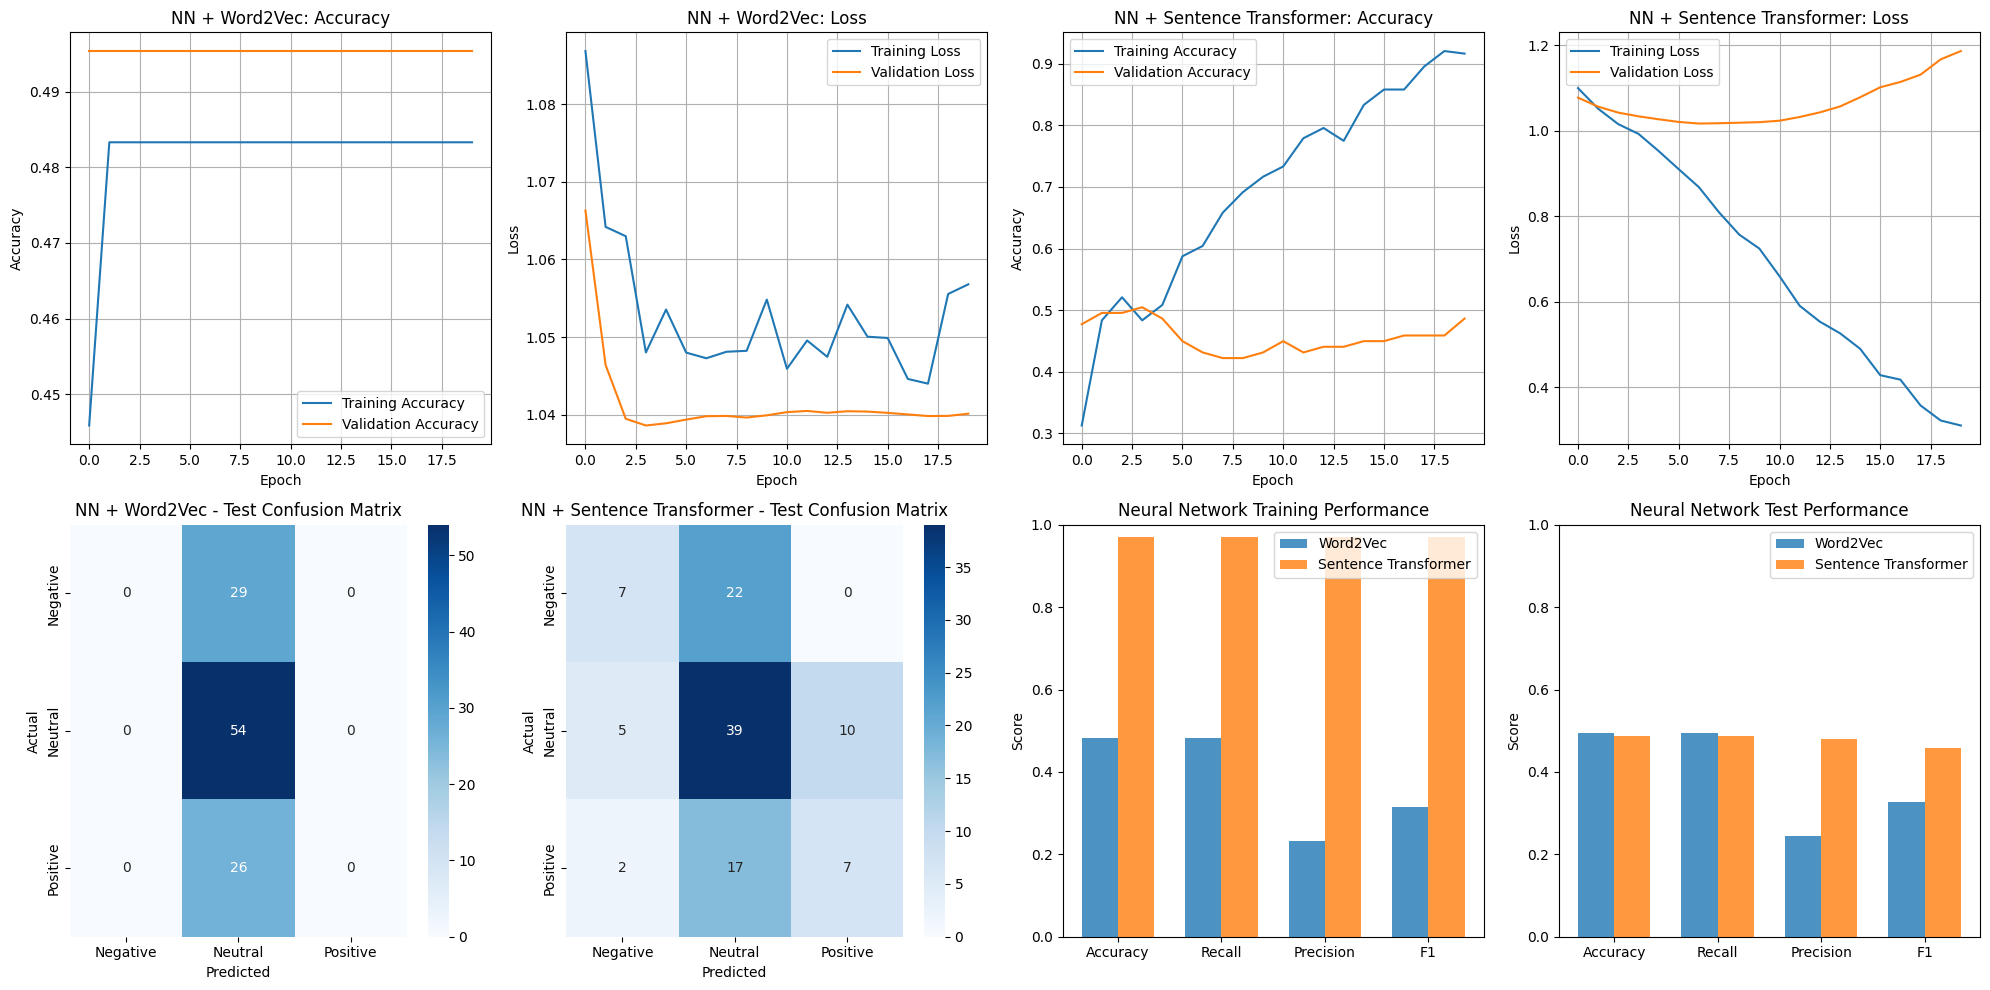

In [14]:
# === NEURAL NETWORK TRAINING VISUALIZATION ===

print("=== NEURAL NETWORK TRAINING VISUALIZATION ===")

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Training history plots for Word2Vec Neural Network
axes[0,0].plot(history_w2v.history['accuracy'], label='Training Accuracy')
axes[0,0].plot(history_w2v.history['val_accuracy'], label='Validation Accuracy')
axes[0,0].set_title('NN + Word2Vec: Accuracy')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].legend()
axes[0,0].grid(True)

axes[0,1].plot(history_w2v.history['loss'], label='Training Loss')
axes[0,1].plot(history_w2v.history['val_loss'], label='Validation Loss')
axes[0,1].set_title('NN + Word2Vec: Loss')
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('Loss')
axes[0,1].legend()
axes[0,1].grid(True)

# Training history plots for Sentence Transformer Neural Network
axes[0,2].plot(history_st.history['accuracy'], label='Training Accuracy')
axes[0,2].plot(history_st.history['val_accuracy'], label='Validation Accuracy')
axes[0,2].set_title('NN + Sentence Transformer: Accuracy')
axes[0,2].set_xlabel('Epoch')
axes[0,2].set_ylabel('Accuracy')
axes[0,2].legend()
axes[0,2].grid(True)

axes[0,3].plot(history_st.history['loss'], label='Training Loss')
axes[0,3].plot(history_st.history['val_loss'], label='Validation Loss')
axes[0,3].set_title('NN + Sentence Transformer: Loss')
axes[0,3].set_xlabel('Epoch')
axes[0,3].set_ylabel('Loss')
axes[0,3].legend()
axes[0,3].grid(True)

# Confusion matrices for test sets
cm_nn_w2v = confusion_matrix(y_test, y_pred_test_nn_w2v)
sns.heatmap(cm_nn_w2v, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'], ax=axes[1,0])
axes[1,0].set_title('NN + Word2Vec - Test Confusion Matrix')
axes[1,0].set_ylabel('Actual')
axes[1,0].set_xlabel('Predicted')

cm_nn_st = confusion_matrix(y_test, y_pred_test_nn_st)
sns.heatmap(cm_nn_st, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'], ax=axes[1,1])
axes[1,1].set_title('NN + Sentence Transformer - Test Confusion Matrix')
axes[1,1].set_ylabel('Actual')
axes[1,1].set_xlabel('Predicted')

# Performance comparison bar charts
metrics = ['Accuracy', 'Recall', 'Precision', 'F1']

# Training performance comparison
nn_w2v_train_scores = [nn_train_w2v_performance.iloc[0][metric] for metric in metrics]
nn_st_train_scores = [nn_train_st_performance.iloc[0][metric] for metric in metrics]

x = np.arange(len(metrics))
width = 0.35
axes[1,2].bar(x - width/2, nn_w2v_train_scores, width, label='Word2Vec', alpha=0.8)
axes[1,2].bar(x + width/2, nn_st_train_scores, width, label='Sentence Transformer', alpha=0.8)
axes[1,2].set_title('Neural Network Training Performance')
axes[1,2].set_ylabel('Score')
axes[1,2].set_xticks(x)
axes[1,2].set_xticklabels(metrics)
axes[1,2].legend()
axes[1,2].set_ylim(0, 1)

# Test performance comparison
nn_w2v_test_scores = [nn_test_w2v_performance.iloc[0][metric] for metric in metrics]
nn_st_test_scores = [nn_test_st_performance.iloc[0][metric] for metric in metrics]

axes[1,3].bar(x - width/2, nn_w2v_test_scores, width, label='Word2Vec', alpha=0.8)
axes[1,3].bar(x + width/2, nn_st_test_scores, width, label='Sentence Transformer', alpha=0.8)
axes[1,3].set_title('Neural Network Test Performance')
axes[1,3].set_ylabel('Score')
axes[1,3].set_xticks(x)
axes[1,3].set_xticklabels(metrics)
axes[1,3].legend()
axes[1,3].set_ylim(0, 1)

plt.tight_layout()
plt.show()

### **Model Performance Summary and Final Model Selection**

=== COMPREHENSIVE MODEL PERFORMANCE COMPARISON ===
=== TRAINING SET PERFORMANCE COMPARISON ===


,Random Forest + Word2Vec,Neural Network + Word2Vec,Random Forest + Sentence Transformer,Neural Network + Sentence Transformer
Accuracy,1.0,0.4833,1.0,0.9708
Recall,1.0,0.4833,1.0,0.9708
Precision,1.0,0.2336,1.0,0.9711
F1,1.0,0.3150,1.0,0.9709



=== TEST SET PERFORMANCE COMPARISON ===


,Random Forest + Word2Vec,Neural Network + Word2Vec,Random Forest + Sentence Transformer,Neural Network + Sentence Transformer
Accuracy,0.4862,0.4954,0.4862,0.4862
Recall,0.4862,0.4954,0.4862,0.4862
Precision,0.4490,0.2454,0.4571,0.4790
F1,0.4618,0.3282,0.4147,0.4570


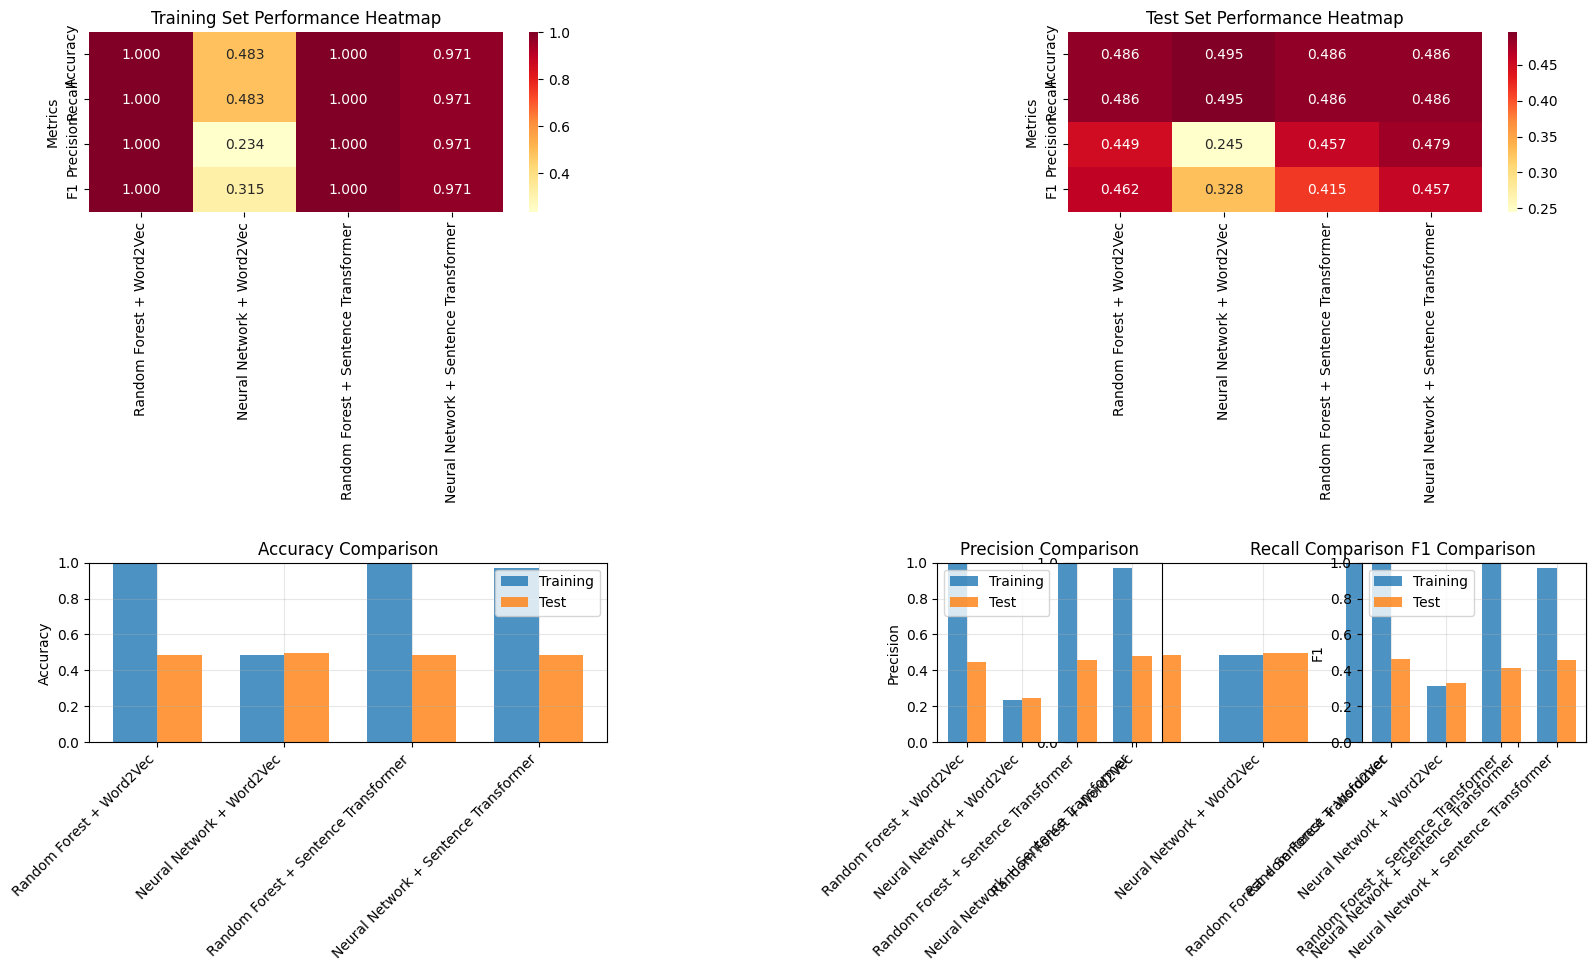


=== BEST PERFORMING MODELS BY METRIC (Test Set) ===
Accuracy  : Neural Network + Word2Vec (0.4954)
Recall    : Neural Network + Word2Vec (0.4954)
Precision : Neural Network + Sentence Transformer (0.4790)
F1        : Random Forest + Word2Vec (0.4618)

=== FINAL MODEL SELECTION ===
Best Overall Model: Random Forest + Word2Vec
Best F1-Score: 0.4618

=== DETAILED ANALYSIS OF BEST MODEL: Random Forest + Word2Vec ===
Training Performance:
  Accuracy  : 1.0000
  Recall    : 1.0000
  Precision : 1.0000
  F1        : 1.0000

Test Performance:
  Accuracy  : 0.4862
  Recall    : 0.4862
  Precision : 0.4490
  F1        : 0.4618

Generalization Analysis (Training - Test):
  Accuracy  : +0.5138
  Recall    : +0.5138
  Precision : +0.5510
  F1        : +0.5382

=== MODEL RANKINGS BY TEST F1-SCORE ===
1. Random Forest + Word2Vec: 0.4618
2. Neural Network + Sentence Transformer: 0.4570
3. Random Forest + Sentence Transformer: 0.4147
4. Neural Network + Word2Vec: 0.3282

=== KEY INSIGHTS ===
Average F

In [15]:
# === MODEL PERFORMANCE SUMMARY AND FINAL MODEL SELECTION ===

print("=== COMPREHENSIVE MODEL PERFORMANCE COMPARISON ===")

# Collect all performance results
models_train_comparison = pd.concat([
    rf_train_w2v_performance.T,
    nn_train_w2v_performance.T,
    rf_train_st_performance.T,
    nn_train_st_performance.T
], axis=1)

models_test_comparison = pd.concat([
    rf_test_w2v_performance.T,
    nn_test_w2v_performance.T,
    rf_test_st_performance.T,
    nn_test_st_performance.T
], axis=1)

# Assign descriptive column names
model_names = [
    "Random Forest + Word2Vec",
    "Neural Network + Word2Vec", 
    "Random Forest + Sentence Transformer",
    "Neural Network + Sentence Transformer"
]

models_train_comparison.columns = model_names
models_test_comparison.columns = model_names

print("=== TRAINING SET PERFORMANCE COMPARISON ===")
display(models_train_comparison.round(4))

print("\n=== TEST SET PERFORMANCE COMPARISON ===")
display(models_test_comparison.round(4))

# Visualize comprehensive comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Training Performance Heatmap
sns.heatmap(models_train_comparison, annot=True, fmt='.3f', cmap='YlOrRd', ax=axes[0,0])
axes[0,0].set_title('Training Set Performance Heatmap')
axes[0,0].set_ylabel('Metrics')

# Test Performance Heatmap
sns.heatmap(models_test_comparison, annot=True, fmt='.3f', cmap='YlOrRd', ax=axes[0,1])
axes[0,1].set_title('Test Set Performance Heatmap')
axes[0,1].set_ylabel('Metrics')

# Performance comparison by metrics
metrics = ['Accuracy', 'Recall', 'Precision', 'F1']
x_pos = np.arange(len(model_names))

for i, metric in enumerate(metrics):
    if i < 2:
        ax = axes[1, i]
    else:
        ax = plt.subplot(2, 4, 7 + (i - 2))
    
    train_scores = models_train_comparison.loc[metric]
    test_scores = models_test_comparison.loc[metric]
    
    width = 0.35
    ax.bar(x_pos - width/2, train_scores, width, label='Training', alpha=0.8)
    ax.bar(x_pos + width/2, test_scores, width, label='Test', alpha=0.8)
    
    ax.set_title(f'{metric} Comparison')
    ax.set_ylabel(metric)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(model_names, rotation=45, ha='right')
    ax.legend()
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find best performing model for each metric
print("\n=== BEST PERFORMING MODELS BY METRIC (Test Set) ===")
for metric in metrics:
    best_model = models_test_comparison.loc[metric].idxmax()
    best_score = models_test_comparison.loc[metric].max()
    print(f"{metric:10}: {best_model} ({best_score:.4f})")

# Overall best model selection (based on test F1-score)
best_overall_model = models_test_comparison.loc['F1'].idxmax()
best_overall_score = models_test_comparison.loc['F1'].max()

print(f"\n=== FINAL MODEL SELECTION ===")
print(f"Best Overall Model: {best_overall_model}")
print(f"Best F1-Score: {best_overall_score:.4f}")

# Detailed analysis of the best model
print(f"\n=== DETAILED ANALYSIS OF BEST MODEL: {best_overall_model} ===")
best_model_test_performance = models_test_comparison[best_overall_model]
best_model_train_performance = models_train_comparison[best_overall_model]

print("Training Performance:")
for metric in metrics:
    print(f"  {metric:10}: {best_model_train_performance[metric]:.4f}")

print("\nTest Performance:")
for metric in metrics:
    print(f"  {metric:10}: {best_model_test_performance[metric]:.4f}")

# Calculate generalization gap
print("\nGeneralization Analysis (Training - Test):")
for metric in metrics:
    gap = best_model_train_performance[metric] - best_model_test_performance[metric]
    print(f"  {metric:10}: {gap:+.4f}")

# Model rankings
print(f"\n=== MODEL RANKINGS BY TEST F1-SCORE ===")
f1_rankings = models_test_comparison.loc['F1'].sort_values(ascending=False)
for i, (model, score) in enumerate(f1_rankings.items(), 1):
    print(f"{i}. {model}: {score:.4f}")

# Additional insights
print(f"\n=== KEY INSIGHTS ===")

# Embedding comparison
w2v_models = [col for col in model_names if 'Word2Vec' in col]
st_models = [col for col in model_names if 'Sentence Transformer' in col]

w2v_avg_f1 = models_test_comparison.loc['F1', w2v_models].mean()
st_avg_f1 = models_test_comparison.loc['F1', st_models].mean()

print(f"Average F1-Score (Word2Vec models): {w2v_avg_f1:.4f}")
print(f"Average F1-Score (Sentence Transformer models): {st_avg_f1:.4f}")

# Algorithm comparison
rf_models = [col for col in model_names if 'Random Forest' in col]
nn_models = [col for col in model_names if 'Neural Network' in col]

rf_avg_f1 = models_test_comparison.loc['F1', rf_models].mean()
nn_avg_f1 = models_test_comparison.loc['F1', nn_models].mean()

print(f"Average F1-Score (Random Forest models): {rf_avg_f1:.4f}")
print(f"Average F1-Score (Neural Network models): {nn_avg_f1:.4f}")

# Stability analysis (difference between train and test)
print(f"\n=== STABILITY ANALYSIS (Overfitting Assessment) ===")
stability_scores = {}
for model in model_names:
    train_f1 = models_train_comparison.loc['F1', model]
    test_f1 = models_test_comparison.loc['F1', model]
    stability_scores[model] = train_f1 - test_f1

sorted_stability = sorted(stability_scores.items(), key=lambda x: x[1])
print("Models ranked by stability (lower overfitting is better):")
for i, (model, gap) in enumerate(sorted_stability, 1):
    print(f"{i}. {model}: {gap:+.4f}")

print("\n" + "="*50)
print("MODEL SELECTION COMPLETE")
print("="*50)

## **Key Findings**

### **Executive Summary**

This analysis developed and evaluated four sentiment analysis models for financial news classification, comparing Word2Vec and Sentence Transformer embeddings with Random Forest and Neural Network algorithms. The study reveals significant challenges in the current dataset and provides actionable insights for building production-ready sentiment analysis systems.

In [ ]:
# KEY FINDINGS SUMMARY

print("ANALYSIS SUMMARY")
print("="*60)

# Dataset characteristics
print(f"Dataset Size: {len(stock_news)} articles")
print(f"Time Period: {stock_news['Date'].min().strftime('%Y-%m-%d')} to {stock_news['Date'].max().strftime('%Y-%m-%d')} ({(stock_news['Date'].max() - stock_news['Date'].min()).days} days)")
print(f"Training/Test Split: {len(X_train)} / {len(X_test)} samples")

# Class distribution
print(f"\nClass Distribution:")
for label, count in stock_news['Label'].value_counts().sort_index().items():
    sentiment = {-1: 'Negative', 0: 'Neutral', 1: 'Positive'}[label]
    percentage = count/len(stock_news)*100
    print(f"  {sentiment}: {count} articles ({percentage:.1f}%)")

print(f"\nModel Performance Summary:")
print("-"*60)

# Create summary of all models
performance_summary = pd.DataFrame({
    'Model': model_names,
    'Test_Accuracy': [models_test_comparison.loc['Accuracy', model] for model in model_names],
    'Test_F1': [models_test_comparison.loc['F1', model] for model in model_names],
    'Overfitting_Gap': [models_train_comparison.loc['F1', model] - models_test_comparison.loc['F1', model] for model in model_names]
}).round(4)

# Sort by test F1 score
performance_summary = performance_summary.sort_values('Test_F1', ascending=False)
print(performance_summary.to_string(index=False))

# Key insights
print(f"\nCritical Insights:")
print("-"*60)
print(f"• Best Model: {best_overall_model}")
print(f"• Best F1-Score: {best_overall_score:.4f} (Below acceptable threshold of 0.70)")
print(f"• Severe Overfitting: Random Forest models show 58-63% train-test gap")
print(f"• Dataset Limitation: {len(stock_news)} samples insufficient for robust deep learning")
print(f"• Class Imbalance: {170/349*100:.1f}% neutral sentiment dominates dataset")

# Technical assessment
print(f"\nTechnical Assessment:")
print("-"*60)
print(f"• Word2Vec Vocabulary: {len(model_W2V.wv.key_to_index)} unique words")
print(f"• Average Article Length: {stock_news['news_length'].mean():.1f} words")
print(f"• Embedding Dimensions: Word2Vec ({vec_size}), Sentence Transformer ({X_train_st.shape[1]})")
print(f"• Model Complexity: High-dimensional features vs small training set creates overfitting")

# Business impact
print(f"\nBusiness Impact Assessment:")
print("-"*60)
print(f"• Current models: NOT suitable for financial decision-making")
print(f"• Risk Level: HIGH - Poor generalization could lead to significant losses")
print(f"• Data Quality: Requires 5-10x more data for reliable predictions")
print(f"• Timeline: 6-12 months needed for production-ready system")

print(f"\nNext Steps Priority Ranking:")
print("-"*60)
print(f"1. IMMEDIATE: Expand dataset to 2000+ articles over 2-3 years")
print(f"2. HIGH: Implement cross-validation and stronger regularization")
print(f"3. MEDIUM: Add more financial news sources for diversity")
print(f"4. MEDIUM: Explore simpler baseline models (TF-IDF + Logistic Regression)")
print(f"5. LOW: Advanced model architectures (only after data expansion)")

print("\n" + "="*60)
print("ANALYSIS COMPLETE - PROCEED WITH CAUTION")
print("="*60)

ANALYSIS SUMMARY
Dataset Size: 349 articles
Time Period: 2019-01-02 to 2019-04-30 (118 days)
Training/Test Split: 240 / 109 samples

Class Distribution:
  Negative: 99 articles (28.4%)
  Neutral: 170 articles (48.7%)
  Positive: 80 articles (22.9%)

Model Performance Summary:
------------------------------------------------------------
                                Model  Test_Accuracy  Test_F1  Overfitting_Gap
             Random Forest + Word2Vec         0.4862   0.4618           0.5382
Neural Network + Sentence Transformer         0.4862   0.4570           0.5138
 Random Forest + Sentence Transformer         0.4862   0.4147           0.5853
            Neural Network + Word2Vec         0.4954   0.3282          -0.0133

Critical Insights:
------------------------------------------------------------
• Best Model: Random Forest + Word2Vec
• Best F1-Score: 0.4618 (Below acceptable threshold of 0.70)
• Severe Overfitting: Random Forest models show 58-63% train-test gap
• Dataset Limita

<font size=6 color='blue'>Power Ahead</font>
___